In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:


def trade_strategy_with_new_rules(df, initial_capital, buy_threshold=0.07, sell_threshold=0.09, min_shares_to_hold=50, initial_shares=0):
    cash = initial_capital
    shares = initial_shares
    transactions = []
    purchase_stage = 0  # Track the stage of purchasing
    prev_row = None
    avg_price = 0

    # Calculate the initial shares to buy based on 31 times rule

    # Iterate over the rows
    for index, row in enumerate(df.itertuples(), 1):
        # set a random chance that we didn't catch the price
        if prev_row is None:
            prev_row = row
            continue

        if index == len(df):
            break

        prev_close = prev_row.Close
        threshold_buy_price = prev_close * (1 - buy_threshold)
        threshold_sell_price = prev_close * (1 + sell_threshold)

        # extreme case1: if today's market drop so much that the threshold_buy is even higher than today High &
        # Check if the threshold is met for buying
        if (row.Low <= threshold_buy_price) and (purchase_stage < 5):
            if threshold_buy_price > row.High:
                buy_price = (row.High + row.Low)/2
            else:
                buy_price = threshold_buy_price

            # shares_to_buy = initial_shares * (2 ** purchase_stage)
            if purchase_stage == 0:
                shares_to_buy = (cash // (31 * buy_price))
            else:
                # shares_to_buy = shares * 2
                shares_to_buy = shares

            # update avg price
            if (shares == 0):
                avg_price = buy_price
            else:
                avg_price = (avg_price * shares + buy_price * shares_to_buy) / (shares + shares_to_buy)
                

            if cash >= shares_to_buy * buy_price:
                cash -= shares_to_buy * buy_price
                shares += shares_to_buy
                transactions.append({
                    'Date': row.Date,
                    'Action': 'BUY',
                    'Open': round(row.Open, 2),
                    'High': round(row.High, 2),
                    'Low': round(row.Low, 2),
                    'Close': round(row.Close, 2),
                    'Stage': purchase_stage,

                    'Prev Close': round(prev_close, 2),
                    'Threshold Buy Price': round(threshold_buy_price, 2),
                    'Threshold Sell Price': round(threshold_sell_price, 2),
                    'Price': round(buy_price, 2),
                    'Price(buy)': round(buy_price, 2),
                    'Price(sell)': None,
                    'Shares to trade': shares_to_buy,
                    'Total Shares': shares,
                    'Total Cash': round(cash, 2),
                    'Total Capital (Cash + Shares)': round(shares * row.Close + cash, 2)
                })
                purchase_stage += 1
            else:
                transactions.append({
                    'Date': row.Date,
                    'Action': 'HOLD (not enough Cash or decide not to)',
                    'Open': round(row.Open, 2),
                    'High': round(row.High, 2),
                    'Low': round(row.Low, 2),
                    'Close': round(row.Close, 2),
                    'Stage': purchase_stage,
                    'Prev Close': round(prev_close, 2),
                    'Price': round(row.Close, 2),
                    'Threshold Buy Price': round(threshold_buy_price, 2),
                    'Threshold Sell Price': round(threshold_sell_price, 2),
                    'Shares to trade': 0,
                    'Total Shares': shares,
                    'Total Cash': round(cash, 2),
                    'Total Capital (Cash + Shares)': round(shares * row.Close + cash, 2)
                })

        # extreme case2: if today's market raise so much that the threshold_sell is even lower than today Low &
        # Check if the threshold is met for selling
        elif shares > 0 and (row.High >= threshold_sell_price):
            if (threshold_sell_price < row.Low):
                sell_price = (row.High + row.Low) / 2
            else:
                sell_price = threshold_sell_price

            if (shares <= min_shares_to_hold):
                shares_to_sell = shares
            else:
                shares_to_sell = shares // 2

            # cehck if sell_price is higher than avg price of shares holding, and decide if sell
            # avg_price = (avg_price * shares + sell_price * shares_to_sell) / (shares + shares_to_sell)
            if (sell_price > avg_price):
                # sell_price = threshold_sell_price
                # sell_price = (threshold_sell_price + row.High) / 2
                cash += shares_to_sell * sell_price
                shares -= shares_to_sell
                transactions.append({
                    'Date': row.Date,
                    'Action': 'SELL',
                    'Open': round(row.Open, 2),
                    'High': round(row.High, 2),
                    'Low': round(row.Low, 2),
                    'Close': round(row.Close, 2),
                    'Stage': purchase_stage,  # Using the same stage variable for selling

                    'Prev Close': round(prev_close, 2),
                    'Threshold Buy Price': round(threshold_buy_price, 2),
                    'Threshold Sell Price': round(threshold_sell_price, 2),
                    'Price': round(sell_price, 2),
                    'Price(buy)': None,
                    'Price(sell)': round(sell_price, 2),

                    'Shares to trade': shares_to_sell,
                    'Total Shares': shares,
                    'Total Cash': round(cash, 2),
                    'Total Capital (Cash + Shares)': round(shares * row.Close + cash, 2)
                })
                purchase_stage = 0 if purchase_stage <= 0 else purchase_stage - 1
                if shares < min_shares_to_hold:
                    # Reset purchase stage if shares were below minimum threshold
                    purchase_stage = 0
            else:
                transactions.append({
                    'Date': row.Date,
                    'Action': 'HOLD (not good price)',
                    'Open': round(row.Open, 2),
                    'High': round(row.High, 2),
                    'Low': round(row.Low, 2),
                    'Close': round(row.Close, 2),
                    'Stage': purchase_stage,
                    'Prev Close': round(prev_close, 2),
                    'Price': round(row.Close, 2),
                    'Threshold Buy Price': round(threshold_buy_price, 2),
                    'Threshold Sell Price': round(threshold_sell_price, 2),
                    'Shares to trade': 0,
                    'Total Shares': shares,
                    'Total Cash': round(cash, 2),
                    'Total Capital (Cash + Shares)': round(shares * row.Close + cash, 2)
                })
        else:
            transactions.append({
                'Date': row.Date,
                'Action': 'HOLD',
                'Open': round(row.Open, 2),
                'High': round(row.High, 2),
                'Low': round(row.Low, 2),
                'Close': round(row.Close, 2),
                'Stage': purchase_stage,
                'Prev Close': round(prev_close, 2),
                'Price': round(row.Close, 2),
                'Threshold Buy Price': round(threshold_buy_price, 2),
                'Threshold Sell Price': round(threshold_sell_price, 2),
                'Shares to trade': 0,
                'Total Shares': shares,
                'Total Cash': round(cash, 2),
                'Total Capital (Cash + Shares)': round(shares * row.Close + cash, 2)
            })

        prev_row = row

    return transactions

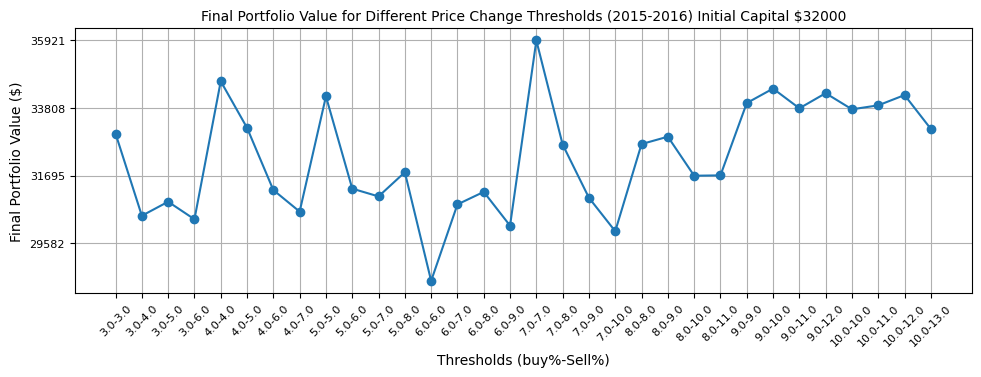

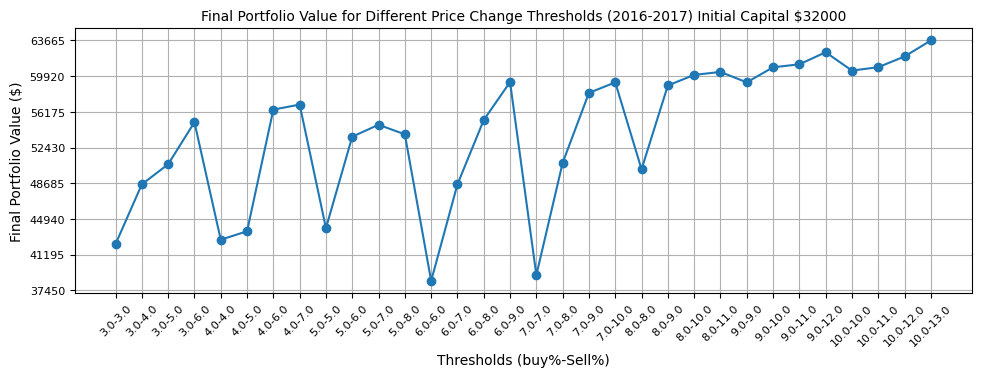

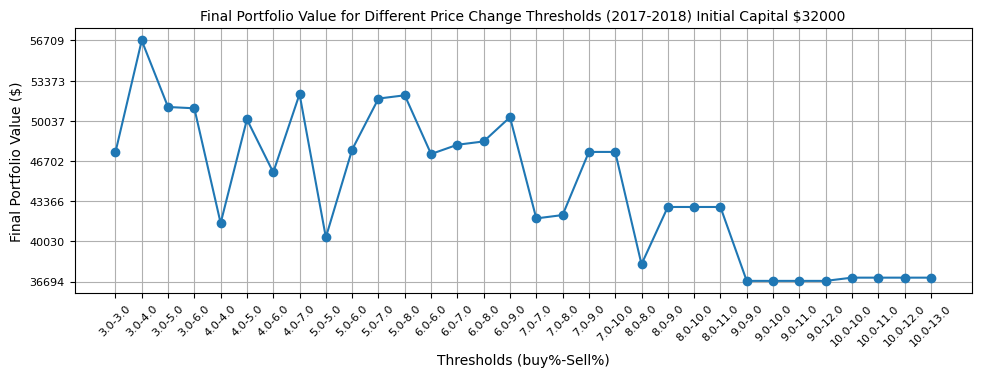

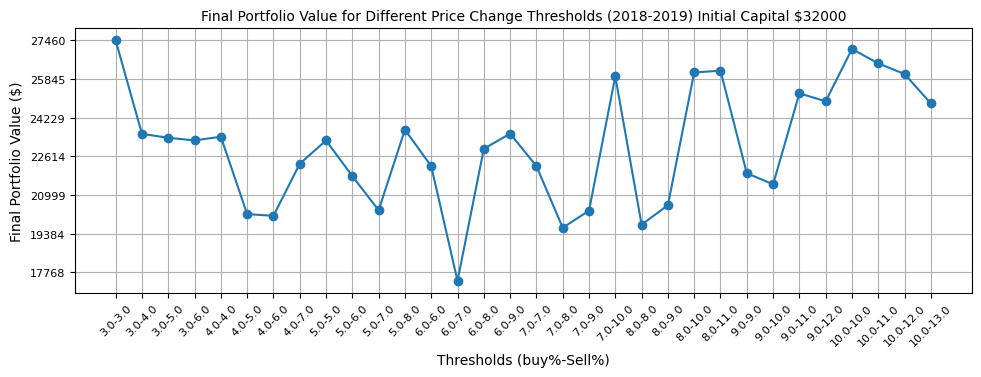

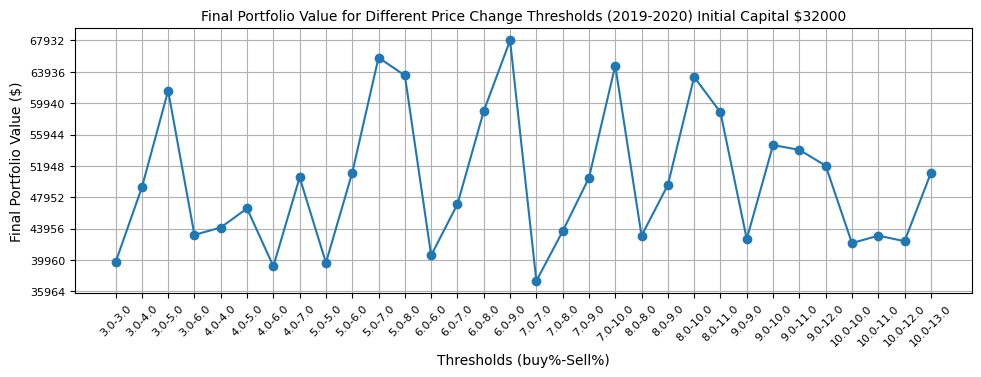

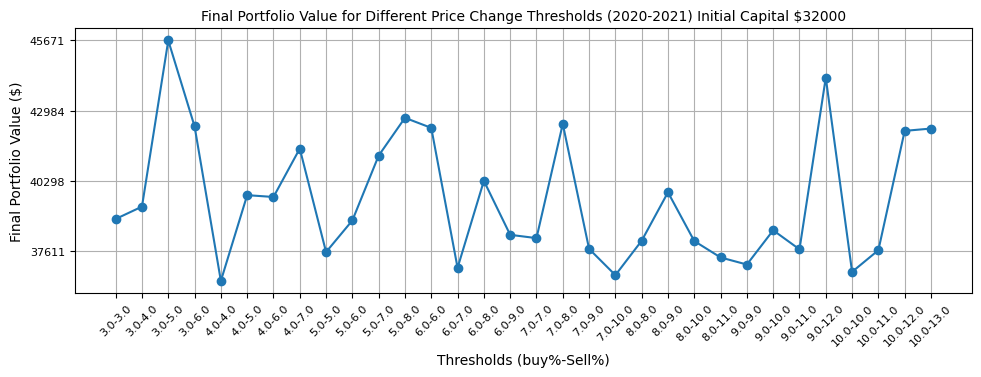

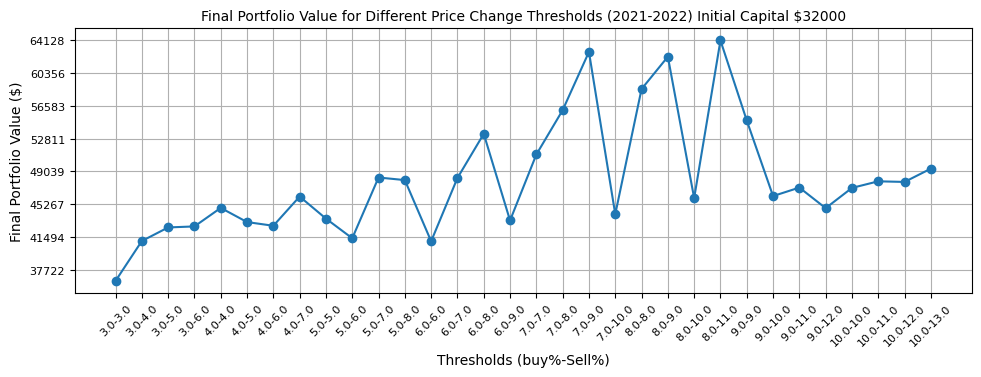

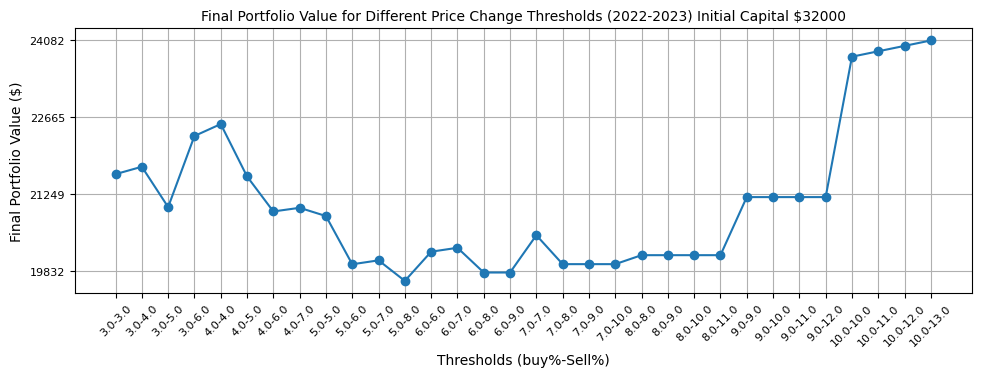

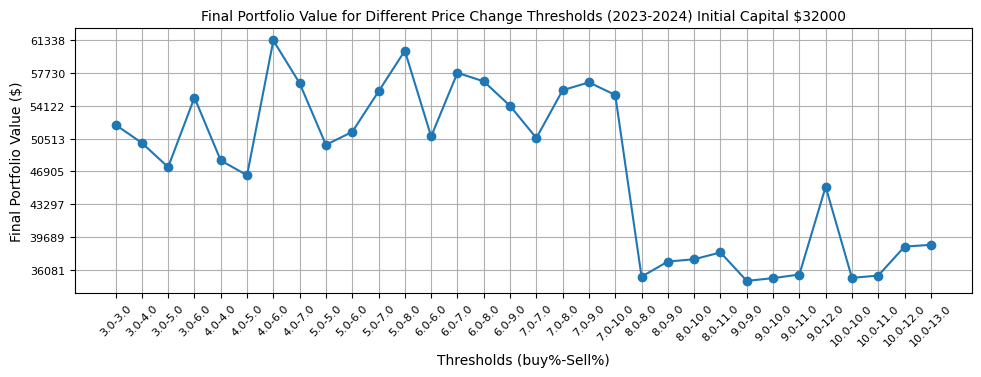

In [12]:
# YoY same initial Value

# soxl_data = pd.read_csv('SOXL.csv')
start_year = '2015'
end_year = '2024'
# buy_threshold = 0.07
# sell_threshold = 0.09
initial_capital = 32000

# soxl_data = soxl_data[soxl_data['Date'] >= start_year+ '-01-01']
# soxl_data = soxl_data[soxl_data['Date'] <= end_year + '-01-01']

threshold_list = np.arange(0.03, 0.10, 0.01)

simulation_results_list = []
simulation_results = {}

for year in range(int(start_year), int(end_year)):
    soxl_data = pd.read_csv('../data/SOXL.csv')
    startYear = str(year)
    endYear = str(year+1)
    soxl_data = soxl_data[soxl_data['Date'] >= startYear + '-01-01']
    soxl_data = soxl_data[soxl_data['Date'] <= endYear + '-01-01']
    for threshold in threshold_list:
        for i in np.arange(0,0.04,0.01):
            buy_threshold = threshold
            sell_threshold = threshold + i
            transaction_history = trade_strategy_with_new_rules(soxl_data, initial_capital=initial_capital, buy_threshold=buy_threshold, sell_threshold=sell_threshold, min_shares_to_hold=50)
            transaction_history_df = pd.DataFrame(transaction_history)
            if (transaction_history_df.shape[0] == 0):
                continue
            # get the last row
            last_row = transaction_history_df.iloc[-1]
            simulation_results[str(round(buy_threshold*100,2)) + "-" + str(round(sell_threshold*100,2))] = last_row["Total Capital (Cash + Shares)"]

        # display(simulation_results)

    thresholds = list(simulation_results.keys())

    values = list(simulation_results.values())

    plt.figure(figsize=(10, 4))
    plt.plot(thresholds, values, marker='o')
    plt.title('Final Portfolio Value for Different Price Change Thresholds (' + str(year) + '-' + str(year+1) + ') Initial Capital $' + str(initial_capital), fontsize=10)
    plt.xlabel('Thresholds (buy%-Sell%)')
    plt.ylabel('Final Portfolio Value ($)')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    #set x label font size
    plt.xticks(fontsize=8)
    #set y label font size
    plt.yticks(fontsize=8)
    #set number of ticks
    #set y axis to be linear and ticks to be 10, and not use the scientific notation, and make y axis more dense
    plt.yscale('linear')
    plt.yticks(np.linspace(0, max(values), 18))
    plt.ticklabel_format(style='plain', axis='y')
    plt.locator_params(axis='y', tight=True)
    plt.show()

    # if (trans_hist_df.shape[0] == 0):
    #     continue
    # last_row = trans_hist_df.iloc[-1]
    # # print(last_row)
    # # Save the transaction history to a CSV file
    # trans_hist_df.to_csv('trans_hist_'+startYear+'_'+endYear+'_' + 'capital_'+str(initial_capital)+'_threshold_' + str(
    #     target_threshold) + '_finalVal_' + str(last_row["Total Capital (Cash + Shares)"]) + '.csv', index=False)
    # initial_capital = int(last_row["Total Capital (Cash + Shares)"])
    # initial_shares = int(last_row["Total Shares"])
    # print('Initial Capital for ' + str(year+1) + ' is ' + str(initial_capital))




In [7]:
# YoY trading strategy - accurate year

start_year = '2020'
end_year = '2024'
start_date = start_year + '-01-01'
end_date = end_year + '-01-01'
buy_threshold = 0.07
sell_threshold = 0.09
min_shares_to_hold = 30
initial_capital = 16000
initial_shares = 0
print("start_year: ", start_year)
print("end_year: ", end_year)
print("buy_threshold: ", buy_threshold)
print("sell_threshold: ", sell_threshold)
print("min_shares_to_hold: ", min_shares_to_hold)
print("initial_capital: ", initial_capital)
print()
print("Simulating starts....")

soxl_data = pd.read_csv('../data/SOXL.csv')
soxl_data = soxl_data[soxl_data['Date'] >= start_date]
soxl_data = soxl_data[soxl_data['Date'] <= end_date]



# # Run the modified trade strategy with new buying and selling criteria
trans_hist = trade_strategy_with_new_rules(
    soxl_data, initial_capital=initial_capital, buy_threshold=buy_threshold, sell_threshold=sell_threshold, min_shares_to_hold=min_shares_to_hold, initial_shares=initial_shares)
trans_hist_df = pd.DataFrame(
    trans_hist)
# # get the last row
last_row = trans_hist_df.iloc[-1]
# print(last_row)
# Save the transaction history to a CSV file
trans_hist_df.to_csv('trans_hist_'+start_year+'_'+end_year+'_' + 'capital_'+str(initial_capital)+'_threshold_' + str(
    buy_threshold)+ '_' + str(sell_threshold) + '_finalVal_' + str(last_row["Total Capital (Cash + Shares)"]) + '.csv', index=False)
initial_shares = int(last_row["Total Shares"])
initial_capital = int(last_row["Total Capital (Cash + Shares)"]) - initial_shares * last_row["Close"]
print('Initial Capital for ' + str(start_year) + ' is ' + str(initial_capital))

start_year:  2020
end_year:  2024
buy_threshold:  0.07
sell_threshold:  0.09
min_shares_to_hold:  30
initial_capital:  16000

Simulating starts....
Initial Capital for 2020 is 17269.199999999997


In [5]:
# YoY trading strategy

start_year = '2020'
end_year = '2024'
buy_threshold = 0.07
sell_threshold = 0.08
min_shares_to_hold = 50
initial_capital = 32000
initial_shares = 0
print("start_year: ", start_year)
print("end_year: ", end_year)
print("buy_threshold: ", buy_threshold)
print("sell_threshold: ", sell_threshold)
print("min_shares_to_hold: ", min_shares_to_hold)
print("initial_capital: ", initial_capital)
print()
print("Simulating starts....")

for year in range(int(start_year), int(end_year)):
    soxl_data = pd.read_csv('../data/SOXL.csv')
    startYear = str(year)
    endYear = str(year+1)
    soxl_data = soxl_data[soxl_data['Date'] >= startYear + '-01-01']
    soxl_data = soxl_data[soxl_data['Date'] <= endYear + '-01-01']

    

    # # Run the modified trade strategy with new buying and selling criteria
    trans_hist = trade_strategy_with_new_rules(
        soxl_data, initial_capital=initial_capital, buy_threshold=buy_threshold, sell_threshold=sell_threshold, min_shares_to_hold=min_shares_to_hold, initial_shares=initial_shares)
    trans_hist_df = pd.DataFrame(
        trans_hist)
    # # get the last row
    if (trans_hist_df.shape[0] == 0):
        continue
    last_row = trans_hist_df.iloc[-1]
    # print(last_row)
    # Save the transaction history to a CSV file
    trans_hist_df.to_csv('trans_hist_'+startYear+'_'+endYear+'_' + 'capital_'+str(initial_capital)+'_buy_threshold_' + str(
        buy_threshold) + '_sell_threshold_' + str(sell_threshold) + '_finalVal_' + str(last_row["Total Capital (Cash + Shares)"]) + '.csv', index=False)
    initial_shares = int(last_row["Total Shares"])
    initial_capital = int(last_row["Total Capital (Cash + Shares)"]) - initial_shares * last_row["Close"]

    print('Initial Capital for ' + str(year) + ' is ' + str(initial_capital))

start_year:  2020
end_year:  2024
buy_threshold:  0.07
sell_threshold:  0.08
min_shares_to_hold:  50
initial_capital:  32000

Simulating starts....
Initial Capital for 2020 is 32124.02
Initial Capital for 2021 is 43732.68
Initial Capital for 2022 is 23843.92
Initial Capital for 2023 is 30314.02


In [10]:
# batch simulation
start_year = '2017'
end_year = '2024'
buy_threshold = 0.04
sell_threshold = 0.07
min_shares_to_hold = 50
initial_capital = 32000
initial_shares = 0
print("start_year: ", start_year)
print("end_year: ", str(int(end_year)))
print("buy_threshold: ", buy_threshold)
print("sell_threshold: ", sell_threshold)
print("min_shares_to_hold: ", min_shares_to_hold)
print("initial_capital: ", initial_capital)
print()
print("Simulating starts....")

soxl_data = pd.read_csv('../data/SOXL.csv')
startYear = start_year
endYear = str(int(end_year))
soxl_data = soxl_data[soxl_data['Date'] >= startYear + '-01-01']
soxl_data = soxl_data[soxl_data['Date'] <= endYear + '-01-01']

# # Run the modified trade strategy with new buying and selling criteria
trans_hist = trade_strategy_with_new_rules(
    soxl_data, initial_capital=initial_capital, buy_threshold=buy_threshold, sell_threshold=sell_threshold, min_shares_to_hold=min_shares_to_hold, initial_shares=initial_shares)
trans_hist_df = pd.DataFrame(
    trans_hist)
# # get the last row
last_row = trans_hist_df.iloc[-1]
# Save the transaction history to a CSV file
trans_hist_df.to_csv('trans_hist_'+startYear+'_'+endYear+'_' + 'capital_'+str(initial_capital)+'_buy_threshold_' + str(
    buy_threshold) + '_sell_threshold_' + str(sell_threshold) + '_finalVal_' + str(last_row["Total Capital (Cash + Shares)"]) + '.csv', index=False)
initial_capital = int(last_row["Total Capital (Cash + Shares)"])
initial_shares = int(last_row["Total Shares"])
print('Initial Capital as of ' + endYear + '-01-01 is ' + str(initial_capital))

start_year:  2017
end_year:  2024
buy_threshold:  0.04
sell_threshold:  0.07
min_shares_to_hold:  50
initial_capital:  32000

Simulating starts....
Initial Capital as of 2024-01-01 is 118159


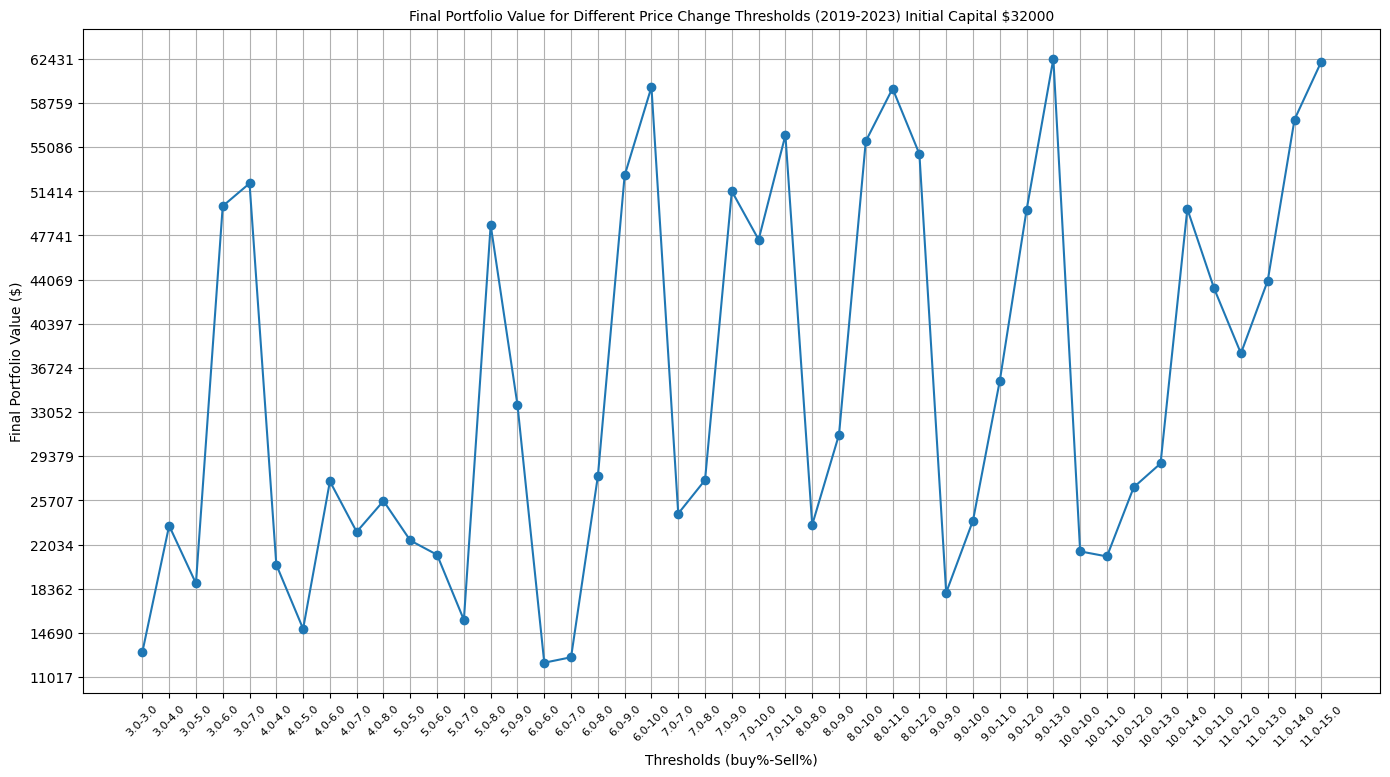

In [81]:
# batch simulatin + plot
# soxl_data = pd.read_csv('SOXL.csv')
start_year = '2019'
end_year = '2023'
# buy_threshold = 0.07
# sell_threshold = 0.09
initial_capital = 32000

# soxl_data = soxl_data[soxl_data['Date'] >= start_year+ '-01-01']
# soxl_data = soxl_data[soxl_data['Date'] <= end_year + '-01-01']

threshold_list = np.arange(0.03, 0.12, 0.01)

simulation_results_list = []
simulation_results = {}


soxl_data = pd.read_csv('../data/SOXL.csv')
startYear = str(start_year)
endYear = str(end_year)
soxl_data = soxl_data[soxl_data['Date'] >= startYear + '-01-01']
soxl_data = soxl_data[soxl_data['Date'] <= endYear + '-01-01']
for threshold in threshold_list:
    for i in np.arange(0,0.05,0.01):
        buy_threshold = threshold
        sell_threshold = threshold + i
        transaction_history = trade_strategy_with_new_rules(soxl_data, initial_capital=initial_capital, buy_threshold=buy_threshold, sell_threshold=sell_threshold, min_shares_to_hold=50)
        transaction_history_df = pd.DataFrame(transaction_history)
        if (transaction_history_df.shape[0] == 0):
            continue
        # get the last row
        last_row = transaction_history_df.iloc[-1]
        simulation_results[str(round(buy_threshold*100,2)) + "-" + str(round(sell_threshold*100,2))] = last_row["Total Capital (Cash + Shares)"]

    # display(simulation_results)

thresholds = list(simulation_results.keys())

values = list(simulation_results.values())

plt.figure(figsize=(14, 8))
plt.plot(thresholds, values, marker='o')
plt.title('Final Portfolio Value for Different Price Change Thresholds (' + str(startYear) + '-' + str(endYear) + ') Initial Capital $' + str(initial_capital), fontsize=10)
plt.xlabel('Thresholds (buy%-Sell%)')
plt.ylabel('Final Portfolio Value ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
#set x label font size
plt.xticks(fontsize=8)
#set y label font size
plt.yticks(fontsize=10)
#set number of ticks
#set y axis to be linear and ticks to be 10, and not use the scientific notation, and make y axis more dense
plt.yscale('linear')
plt.yticks(np.linspace(0, max(values), 18))
plt.ticklabel_format(style='plain', axis='y')
plt.locator_params(axis='y', tight=True)
plt.show()


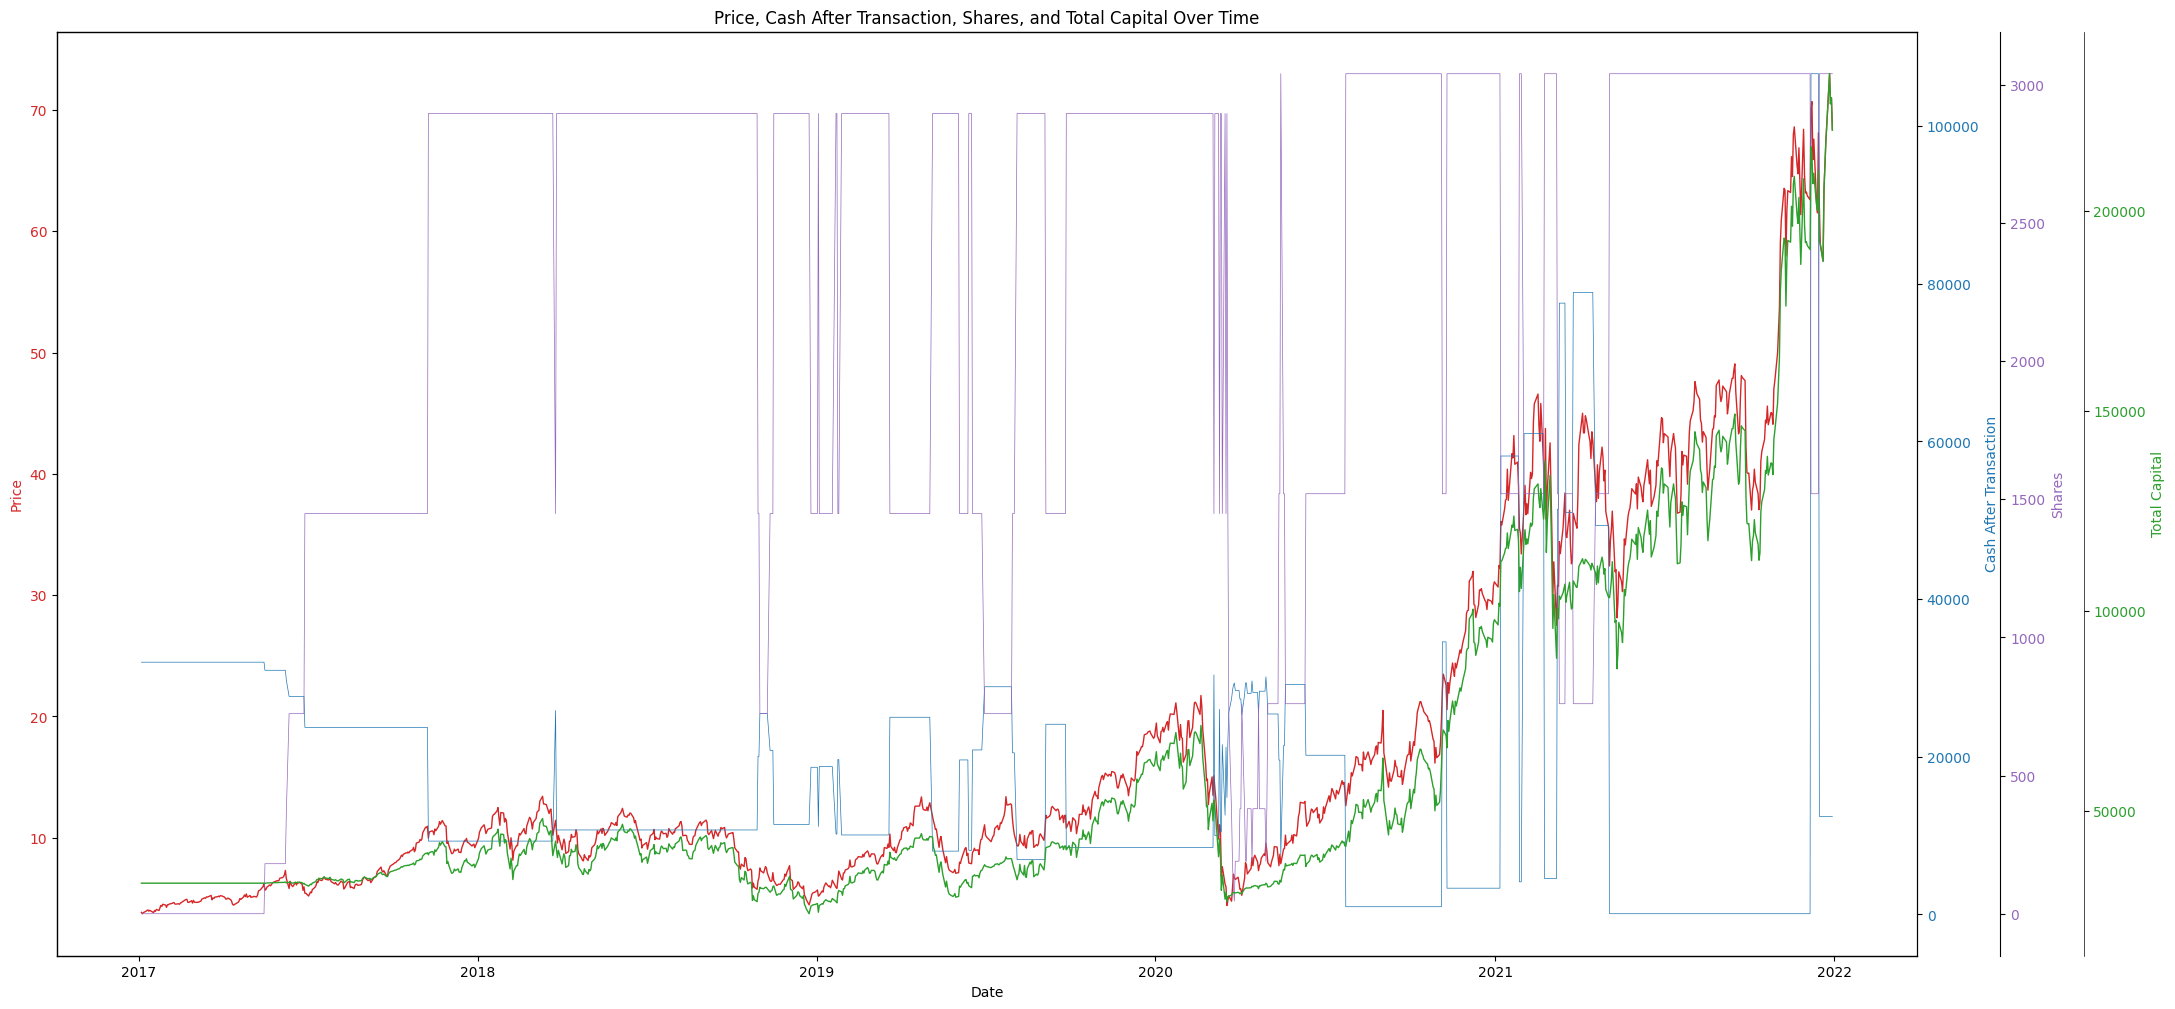

In [74]:
# Plot
# Re-load the data from the newly uploaded file (assuming it's the same format)
data_new = pd.read_csv('trans_hist_2017_2022_capital_32000_buy_threshold_0.09_sell_threshold_0.12_finalVal_220247.74.csv')

# Convert 'Date' to datetime for plotting
data_new['Date'] = pd.to_datetime(data_new['Date'])

# Plotting with multiple y-axes
fig, ax1 = plt.subplots(figsize=(24, 12))

# First y-axis for Price
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(data_new['Date'], data_new['Price'], color=color, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color)

# Second y-axis for Cash After Transaction
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Cash After Transaction', color=color)  
ax2.plot(data_new['Date'], data_new['Total Cash'], color=color, linewidth=0.5)
ax2.tick_params(axis='y', labelcolor=color)
# set thickness of the line


# Third y-axis for Shares
ax3 = ax1.twinx()  
ax3.spines['right'].set_position(('outward', 60))  
color = 'tab:purple'
ax3.set_ylabel('Shares', color=color)  
ax3.plot(data_new['Date'], data_new['Total Shares'], color=color, linewidth=0.5)
ax3.tick_params(axis='y', labelcolor=color)


# Fourth y-axis for Total Capital
ax4 = ax1.twinx()  
ax4.spines['right'].set_position(('outward', 120)) 
ax4.spines['right'].set_linewidth(0.5) 
color = 'tab:green'
ax4.set_ylabel('Total Capital', color=color)  
ax4.plot(data_new['Date'], data_new['Total Capital (Cash + Shares)'], color=color, linewidth=1)
ax4.tick_params(axis='y', labelcolor=color)


# Title
plt.title('Price, Cash After Transaction, Shares, and Total Capital Over Time')

# Show plot
plt.show()
